In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import joblib

In [ ]:
df=pd.read_csv('/content/MeanderingInterploatedUpdated.csv', index_col=0)

# Train a ridge regression model


In [ ]:
df_long = df.melt(id_vars='name', var_name='series', value_name='value')
# turn the df into a long df

df_long['year'] = df_long['name'].str.split('-').str[0].astype(int)
df_long['quarter'] = df_long['name'].str.split('-').str[1].astype(int)
# turn years and quarteres into int

X = df_long[['series', 'year', 'quarter']]
y = df_long['value']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# prepare features
# encode series and quarter but others can ignored - drop one encoded colum to get rid of multicolinearity
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['series', 'quarter', 'year'])  # One-hot encode 'series' and 'quarter'
    ],
    remainder='passthrough'
)


In [ ]:
df_long.head()

,name,series,value,year,quarter
0,1988-1,c1_dist,80.622577,1988,1
1,1988-2,c1_dist,89.201242,1988,2
2,1988-3,c1_dist,90.426766,1988,3
3,1988-4,c1_dist,75.000000,1988,4
4,1989-1,c1_dist,75.485233,1989,1


In [ ]:
print(df_long['series'].unique())

['c1_dist' 'c2_dist' 'c3_dist' 'c4_dist' 'c5_dist' 'c6_dist' 'c7_dist'
 'c8_dist']


In [ ]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=0.4))
])
# In ridge regression, the "alpha" value represents the strength of the regularization penalty applied to the model coefficients,
# essentially controlling how much the model shrinks the coefficients towards zero,
# with a higher alpha value indicating a stronger penalty and more shrinkage towards zero,
# leading to a less complex model with reduced variance but potentially increased bias
# pipleline is there so we cna preprocess before training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 58.07387998283462
Mean Absolute Percentage Error (MAPE): 0.6379730222696095
Mean Squared Error (MSE): 5642.324952551754
Root Mean Squared Error (RMSE): 75.1154108858612


In [ ]:
print(max(df_long['value']), min(df_long['value']))

2748.070232 2.236067977


In [ ]:
baseline_mae = mean_absolute_error(y_test, [y_test.mean()] * len(y_test))
baseline_mape=mean_absolute_percentage_error(y_test, [y_test.mean()] * len(y_test))
baseline_mse=mean_squared_error(y_test, [y_test.mean()] * len(y_test))
baseline_rmse = np.sqrt(mean_squared_error(y_test, [y_test.mean()] * len(y_test)))
print(f"Baseline MAE: {baseline_mae}\nBaseline MAPE: {baseline_mape}\nBaseline MSE: {baseline_mse}\nBaseline RMSE: {baseline_rmse}")

Baseline MAE: 875.069917044649
Baseline MAPE: 9.548969627263297
Baseline MSE: 919603.4243742247
Baseline RMSE: 958.9595530439356


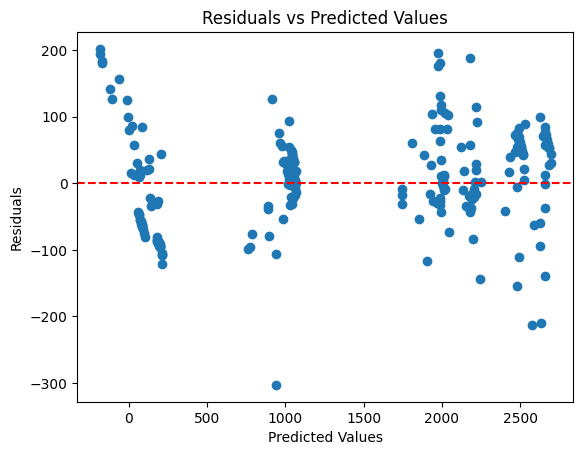

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

In [ ]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")

Durbin-Watson Statistic: 2.020924891282792


In [ ]:
X_train_encoded = model.named_steps['preprocessor'].transform(X_train)
X_test_encoded = model.named_steps['preprocessor'].transform(X_test)

X_test_dense = X_test_encoded.toarray() if hasattr(X_test_encoded, "toarray") else X_test_encoded

# Add a constant term for the predictors
X_test_const = sm.add_constant(X_test_dense)

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_test_const)

print("Breusch-Pagan test results:", bp_test[1])


Breusch-Pagan test results: 0.0005947759109554335


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train_preprocessed = preprocessor.fit_transform(X_train)

# Retrieve feature names from the preprocessor
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['series','quarter', 'year'])
all_feature_names = pd.Index(cat_feature_names.tolist() )

if hasattr(X_train_preprocessed, "toarray"):
    X_train_preprocessed = X_train_preprocessed.toarray()

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = all_feature_names  # Assign the actual feature names
vif_data['VIF'] = [
    variance_inflation_factor(X_train_preprocessed, i)
    for i in range(X_train_preprocessed.shape[1])
]

print(vif_data)


           feature       VIF
0   series_c2_dist  1.827558
1   series_c3_dist  1.811337
2   series_c4_dist  1.847433
3   series_c5_dist  1.858654
4   series_c6_dist  1.865521
5   series_c7_dist  1.822187
6   series_c8_dist  1.853998
7        quarter_2  1.946120
8        quarter_3  1.942928
9        quarter_4  1.965759
10       year_1989  1.203115
11       year_1990  1.212990
12       year_1991  1.243254
13       year_1992  1.215682
14       year_1993  1.215381
15       year_1994  1.206861
16       year_1995  1.228241
17       year_1996  1.209085
18       year_1997  1.214503
19       year_1998  1.254275
20       year_1999  1.228602
21       year_2000  1.194674
22       year_2001  1.222510
23       year_2002  1.267764
24       year_2003  1.193375
25       year_2004  1.214702
26       year_2005  1.251034
27       year_2006  1.226966
28       year_2007  1.204933
29       year_2008  1.194706
30       year_2009  1.205176
31       year_2010  1.233028
32       year_2011  1.220652
33       year_

In [ ]:
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {shapiro_test.pvalue}")

Shapiro-Wilk p-value: 0.0029689855054043602


In [ ]:
joblib.dump(model, '/content/PooledReg.joblib')

['/content/PooledReg.joblib']

In [ ]:
single_obs = pd.DataFrame({
    'series': ['c1_dist'],
    'year': [2025],
    'quarter': [3]
})


In [ ]:
y_pred_single = model.predict(single_obs)

print(f"Predicted value: {y_pred_single[0]}")


Predicted value: 13.034856149408597


In [ ]:

# Access the preprocessor and the trained Ridge model
preprocessor = model.named_steps['preprocessor']
regressor = model.named_steps['regressor']

# Get the feature names from the preprocessor
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['series'])
num_feature_names = ['year', 'quarter']
all_feature_names = np.concatenate([cat_feature_names, num_feature_names])

# Retrieve the coefficients
coefficients = regressor.coef_

# Map coefficients to feature names
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

print(coef_df)


          Feature  Coefficient
0  series_c2_dist    -2.832551
1  series_c3_dist    -8.456818
2  series_c4_dist    -5.431070
3  series_c5_dist    13.168412
4  series_c6_dist    18.917676
5  series_c7_dist   157.730625
6  series_c8_dist   172.549388
7            year     0.050265
8         quarter     0.131284


In [ ]:
print(f"Intercept: {regressor.intercept_}")

Intercept: -89.14560672683886


# Incoroprate PCA to solve multicolinearity

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
df_long['time_dim'] = pca.fit_transform(df_long[['year', 'quarter']])
df_long = df_long.drop(['year', 'quarter'], axis=1)


In [ ]:
df_long.head()

,name,series,value,time_dim
0,1988-1,c1_dist,15.608011,-18.034687
1,1988-2,c1_dist,14.828968,-18.034234
2,1988-3,c1_dist,14.717676,-18.033781
3,1988-4,c1_dist,15.608011,-18.033327
4,1989-1,c1_dist,15.576630,-17.034687


In [ ]:
X = df_long[['series', 'time_dim']]
y = df_long['value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# prepare features
# encode series but others can ignored - drop one encoded colum to get rid of multicolinearity
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['series'])
    ],
    remainder='passthrough'
)


In [ ]:
model2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=0.4))
])
# In ridge regression, the "alpha" value represents the strength of the regularization penalty applied to the model coefficients,
# essentially controlling how much the model shrinks the coefficients towards zero,
# with a higher alpha value indicating a stronger penalty and more shrinkage towards zero,
# leading to a less complex model with reduced variance but potentially increased bias
# pipleline is there so we cna preprocess before training
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 4.2785193246318824
Mean Squared Error (MSE): 45.69902459179466
Root Mean Squared Error (RMSE): 6.760105368394391


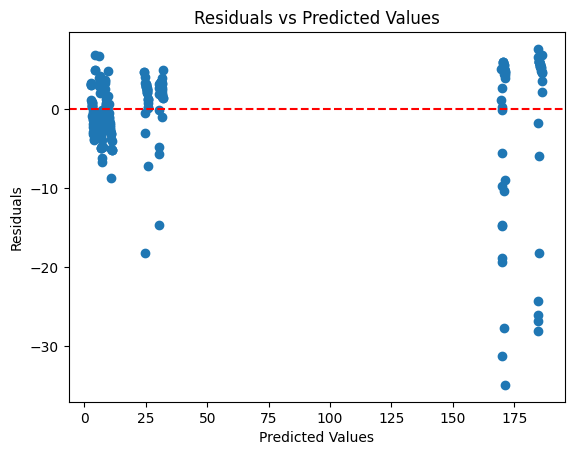

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocess the training data and convert to dense array
X_train_preprocessed = preprocessor.fit_transform(X_train)
if hasattr(X_train_preprocessed, "toarray"):  # Check if it's sparse
    X_train_preprocessed = X_train_preprocessed.toarray()

# Retrieve feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['series'])
num_feature_names = ['time_dim']
all_feature_names = pd.Index(cat_feature_names.tolist() + num_feature_names)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = all_feature_names  # Assign feature names
vif_data['VIF'] = [
    variance_inflation_factor(X_train_preprocessed, i)
    for i in range(X_train_preprocessed.shape[1])
]

print(vif_data)


          feature       VIF
0  series_c2_dist  1.000087
1  series_c3_dist  1.000104
2  series_c4_dist  1.000790
3  series_c5_dist  1.000000
4  series_c6_dist  1.000260
5  series_c7_dist  1.000025
6  series_c8_dist  1.000091
7        time_dim  1.001357


In [ ]:
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {shapiro_test.pvalue}")

Shapiro-Wilk p-value: 1.5200061624589985e-18


In [ ]:
if hasattr(X_test_encoded, "toarray"):
    X_test_encoded = X_test_encoded.toarray()

# Add a constant term for the predictors
X_test_const = sm.add_constant(X_test_encoded)

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_test_const)
print(f"Breusch-Pagan p-value: {bp_test[1]}")

Breusch-Pagan p-value: 5.236557312248925e-06


In [ ]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat}")

Durbin-Watson Statistic: 1.941722067407202


In [ ]:

# Access the preprocessor and the trained Ridge model2
preprocessor = model2.named_steps['preprocessor']
regressor = model2.named_steps['regressor']

# Get the feature names from the preprocessor
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['series'])
num_feature_names = ['time_dim']
all_feature_names = np.concatenate([cat_feature_names, num_feature_names])

# Retrieve the coefficients
coefficients = regressor.coef_

# Map coefficients to feature names
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

print(coef_df)


          Feature  Coefficient
0  series_c2_dist    -1.169097
1  series_c3_dist    -6.816336
2  series_c4_dist    -3.779533
3  series_c5_dist    14.916370
4  series_c6_dist    20.687408
5  series_c7_dist   160.244623
6  series_c8_dist   175.101649
7        time_dim     0.046536


In [ ]:
joblib.dump(model2, '/content/PooleRegressionwPCA.joblib')

['/content/PooleRegressionwPCA.joblib']

# Reducing effect of the scale of the data

---
This helps numerical stability and can converge optimaization faster but the  relative relationships between predictors and their contributions remain consistent. You need to transform the coefficients back to the original scale to interpret them on the original scale.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

df_new = pd.DataFrame({
    'name': df['name'],
    'c1_dist': df['c1_dist'],
    'c3_dist': df['c3_dist'],
    'c4_dist': df['c4_dist'],
    'c6_dist': df['c6_dist'],
    'c8_dist': df['c8_dist']
})
df_long = df_new.melt(id_vars='name', var_name='series', value_name='value')

df_long['year'] = df_long['name'].str.split('-').str[0].astype(int)
df_long['quarter'] = df_long['name'].str.split('-').str[1].astype(int)
# turn years and quarteres into int

X = df_long[['series', 'year', 'quarter']]
y = df_long['value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['series'])
    ],
    remainder='passthrough'
)

model3 = TransformedTargetRegressor(
    regressor=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Ridge())
    ]),
    transformer=StandardScaler()  # Scale y
)


In [ ]:
model3.fit(X_train, y_train)

y_pred = model3.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 4.40459499175373
Mean Squared Error (MSE): 45.17279883569412
Root Mean Squared Error (RMSE): 6.72107125655532


In [ ]:

# Access the trained pipeline from TransformedTargetRegressor
pipeline = model3.regressor_

# Access the Ridge regressor within the pipeline
ridge_model = pipeline.named_steps['regressor']

# Retrieve the coefficients
coefficients = ridge_model.coef_

# Retrieve feature names from the preprocessor
preprocessor_fitted = pipeline.named_steps['preprocessor']
cat_feature_names = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(['series'])
feature_names = list(cat_feature_names) + ['year', 'quarter']  # Add the passthrough feature

# Combine feature names with coefficients
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

print(coeff_df)


          Feature  Coefficient
0  series_c3_dist    -0.099720
1  series_c4_dist    -0.065886
2  series_c6_dist     0.294589
3  series_c8_dist     2.495843
4            year     0.000046
5         quarter    -0.000286


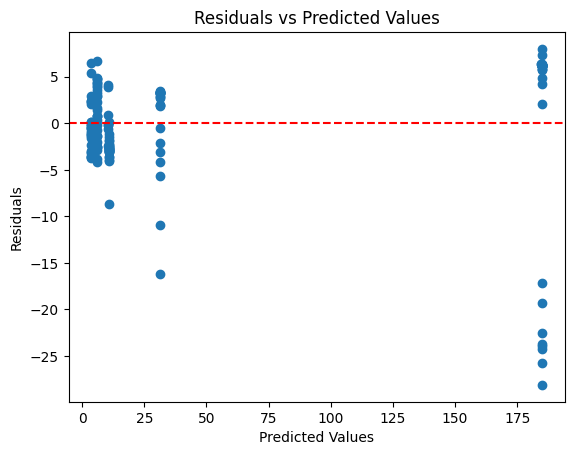

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

In [ ]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
if hasattr(X_train_preprocessed, "toarray"):  # Check if it's sparse
    X_train_preprocessed = X_train_preprocessed.toarray()

# Retrieve feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['series'])
num_feature_names = ['year', 'quarter']
all_feature_names = pd.Index(cat_feature_names.tolist() + num_feature_names)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = all_feature_names  # Assign feature names
vif_data['VIF'] = [
    variance_inflation_factor(X_train_preprocessed, i)
    for i in range(X_train_preprocessed.shape[1])
]

print(vif_data)

          feature       VIF
0  series_c3_dist  2.036026
1  series_c4_dist  2.017890
2  series_c6_dist  2.097255
3  series_c8_dist  2.008407
4            year  8.990920
5         quarter  4.962469


In [ ]:
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {shapiro_test.pvalue}")

Shapiro-Wilk p-value: 8.38695139754749e-14
